# Practical Introduction to Dropout

Paper: http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

### TLDR: Dropout is a stochastic regularization technique for neural networks achieved by adding noise in hidden layers.

## Motivation:

- prevent overfitting
- increase generalization
- a useful and simple regularization method
- performance improvement
- utilizes well-known benefits of model combination
- applicable for both feed-forward and back-propagation networks, and supervised and unsupervised feature learning
- minimize the expected loss function by using noise distribution.
- this forces the network to not rely on one node too much and to not have redundancy in the design. It can also be seen as a regularization as it will yield a model with more generalized features. As a result, this will increase the test-time performance

## Method:
    
- During training: 
    - randomly drop nodes and their corresponding connections; results in a large amount of slightly different "thinned" networks
    - repeat for every epoch, or batch
    - recommended settings for drop out (Note: opposite for keep probability): close to 0 for input layers, and close to 0.50 for hidden layers
    - Back-propagation dropout is a method of randomly turning off weights in the network in the training data
- During testing: use the full network with smaller, regulated, weights

#### Parameters and performance:

- During training: Given a neural network with `n` units, the total number of "thinned" networks is $2^n$. Since the networks share weights and not independent, the number of parameter is $O(n^2)$
<center>
<img src="figures/Dropout_Neural_net.png" width="75%">
</center>

- Zooming in on one node:
<center>
<img src="figures/Dropout_Node_Detail.png" width="60%">
</center>


## Equations
### Feed-forward operation


<center>
<img src="figures/dropout_bernoulli_zoomin.png" width="80%">
</center>

<center>
<img src="figures/dropout_feedforward_equations.png" width="50%">
</center>

# Overfitting

In statistics, overfitting is "the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably". source: https://en.wikipedia.org/wiki/Overfitting

<center>
<img src="figures/dropout_loss.png" width="60%">
</center>
At approximately epoch 4 is where the model is "fit". Prior to that it is underfit, and after that it is overfit.
Source: https://www.machinecurve.com/index.php/2019/12/16/what-is-dropout-reduce-overfitting-in-your-neural-networks/#what-is-dropout-and-how-does-it-work



## Other overfitting mitigation methods (besides dropout):

- early stopping
- weight penalities (L1, L2, Lasso)
- cross validation
- ensembling: bagging and boosting

In [13]:
import argparse
import math
import pickle
import gzip
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import logging as log
import pydot

from keras.datasets import mnist, fashion_mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.layers.core import Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import max_norm

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score

### Back-propogation dropout detailed

The below code illustrates how to implement dropout via back-propogation in detail.

Source: https://github.com/BoulderDS/CSCI5622-machine-learning

In [4]:
# Back-propogation drop-out manually

class Network:
    def __init__(self, sizes, keep_prob=-1):
        self.L = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(n, 1) for n in self.sizes[1:]]
        self.weights = [np.random.randn(n, m) for (
            m, n) in zip(self.sizes[:-1], self.sizes[1:])]
        self.keep_prob = keep_prob
        self.acc_train_array = []
        self.acc_test_array = []

    def g(self, z):
        """
        activation function
        """
        return sigmoid(z)

    def g_prime(self, z):
        """
        derivative of activation function
        """
        return sigmoid_prime(z)

    def forward_prop(self, a):
        """
        memory aware forward propagation for testing
        only.  back_prop implements it's own forward_prop
        """
        ### BEGIN SOLUTION
        for (W, b) in zip(self.weights, self.biases):   
            a = self.g(np.dot(W, a) + b)
        return a
        ### END SOLUTION

    def grad_cost(self, a, y):
        """
        gradient of cost function
        Assumes C(a,y) = (a-y)^2/2
        """
        return (a - y)

    def SGD_train(self, train, epochs, eta, lam=0.0, verbose=True, test=None):
        """
        SGD for training parameters
        epochs is the number of epocs to run
        eta is the learning rate
        lam is the regularization parameter
        If verbose is set will print progressive accuracy updates
        If test set is provided, routine will print accuracy on test set as learning evolves
        """
        n_train = len(train)
        for epoch in range(epochs):
            perm = np.random.permutation(n_train)
            for kk in range(n_train):
                xk = train[perm[kk]][0]
                yk = train[perm[kk]][1]
################ IF DROPOUT IS CALLED, USE IT HERE ###########
                if self.keep_prob > 0:
                    dWs, dbs = self.back_prop_dropout(xk, yk)
                else:
                    dWs, dbs = self.back_prop(xk, yk)
                # L2 regularization
                self.weights = [W - eta * (dW + lam*W)
                                for (W, dW) in zip(self.weights, dWs)]
                # No need to regularize Bias.
                self.biases = [b - eta * (db)
                               for (b, db) in zip(self.biases, dbs)]
            if verbose:
                if epoch == 0 or (epoch + 1) % 20 == 0:
                    acc_train = self.evaluate(train)
                    self.acc_train_array.append(acc_train)
                    if test is not None:
                        acc_test = self.evaluate(test)
                        self.acc_test_array.append(acc_test)
                        print("Epoch {:4d}: Train {:10.5f}, Test {:10.5f}".format(
                            epoch+1, acc_train, acc_test))
                    else:
                        print("Epoch {:4d}: Train {:10.5f}".format(
                            epoch+1, acc_train))

    def back_prop(self, x, y):
        """
        Back propagation for derivatives of C wrt parameters
        """
        db_list = [np.zeros(b.shape) for b in self.biases]
        dW_list = [np.zeros(W.shape) for W in self.weights]
        
        a = x
        a_list = [a]
        z_list = [np.zeros(a.shape)]  # Pad with a placeholder so that indices match

        for W, b in zip(self.weights, self.biases):
            z = np.dot(W, a) + b
            z_list.append(z)
            a = self.g(z)
            a_list.append(a)

        # Back propagate deltas to compute derivatives
        # The following list gives hints on how to do it
        # calculating delta (Error) for the output layer
        # for the appropriate layers compute db_list[ell], dW_list[ell], delta
        
        # calculating delta (Error) for the output layer which is
        delta = self.grad_cost(a_list[self.L-1], y) * \
            self.g_prime(z_list[self.L-1]) # delta(L) = (a-y)*(a)*(1-a)
        
        for ell in range(self.L-2, -1, -1):
            db_list[ell] = delta  # change in bias is just delta
            dW_list[ell] = np.dot(delta, a_list[ell].T) # change in weights is delta.transpose of a(l)
            delta = np.dot(self.weights[ell].T,
                           delta) * self.g_prime(z_list[ell]) # weight(l)_transpose.delta(l+1)*g'(z(l))
            
        return (dW_list, db_list)
    
    def back_prop_dropout(self, x, y):
        """
        Back propagation with dropout on the hidden layers other than the output layer.
        
        Dropout layer can be thought of as a special linear layer between layers.
        """
        
        ################ IF BEGIN DROPOUT LOGIC ###########
        db_list = [np.zeros(b.shape) for b in self.biases]
        dW_list = [np.zeros(W.shape) for W in self.weights]
        
        a = x
        a_list = [a]
        z_list = [np.zeros(a.shape)]  # Pad with a placeholder so that indices match
        masks = [(np.random.rand(*a.shape) < self.keep_prob) / self.keep_prob
                 if i < self.L - 1 else np.ones(a.shape)
                 for (i, a) in enumerate(self.biases)]
        for W, b, mask in zip(self.weights, self.biases, masks):
            z = np.dot(W, a) + b
            z_list.append(z)
            a = self.g(z)
            ######## Multiple A by 1 or 0 at probability keep_prob #######
            a *= mask
            a_list.append(a)
        
        # the mask for final layer is one
        delta = self.grad_cost(a_list[self.L-1], y) * \
            self.g_prime(z_list[self.L-1])
        for ell in range(self.L-2, -1, -1):
            db_list[ell] = delta
            dW_list[ell] = np.dot(delta, a_list[ell].T)
            delta = np.dot(self.weights[ell].T,
                           delta) * self.g_prime(z_list[ell])
            if ell > 0:
                delta *= masks[ell - 1]

        return (dW_list, db_list)

    def evaluate(self, test):
        """
        Evaluate current model on labeled test data
        """
        ctr = 0
        for x, y in test:
            yhat = self.forward_prop(x)
            ctr += np.argmax(yhat) == np.argmax(y)
        return float(ctr) / float(len(test))


def sigmoid(z, threshold=20):
    z = np.clip(z, -threshold, threshold)
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z) * (1.0 - sigmoid(z))


def mnist_digit_show(flatimage, outname=None):

    import matplotlib.pyplot as plt

    image = np.reshape(flatimage, (-1, 14))

    plt.matshow(image, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    if outname:
        plt.savefig(outname)
    else:
        plt.show()

In [5]:
location = './data/tinyMNIST.pkl.gz'
f = gzip.open(location, 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
train, test = u.load()

input_dimensions = len(train[0][0])
output_dimensions = len(train[0][1])
print('Number of Input Features: ', input_dimensions)
print('Number of Output classes: ', output_dimensions)

nns = []
for hidden_layer_dimensions in [20]:
    print('\nHidden Layer Dimensions: ', hidden_layer_dimensions)
    nn = Network([input_dimensions, hidden_layer_dimensions, output_dimensions])
    nns.append(nn)
    nn.SGD_train(train, epochs=200, eta=0.1, lam=0.0001, verbose=True, test=test)

Number of Input Features:  196
Number of Output classes:  10

Hidden Layer Dimensions:  20
Epoch    1: Train    0.35094, Test    0.31012
Epoch   20: Train    0.91717, Test    0.84274
Epoch   40: Train    0.94078, Test    0.86315
Epoch   60: Train    0.95038, Test    0.87115
Epoch   80: Train    0.95798, Test    0.87395
Epoch  100: Train    0.95838, Test    0.86995
Epoch  120: Train    0.95998, Test    0.87435
Epoch  140: Train    0.96118, Test    0.87835
Epoch  160: Train    0.96359, Test    0.87115
Epoch  180: Train    0.96359, Test    0.87435
Epoch  200: Train    0.96439, Test    0.88115


[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]


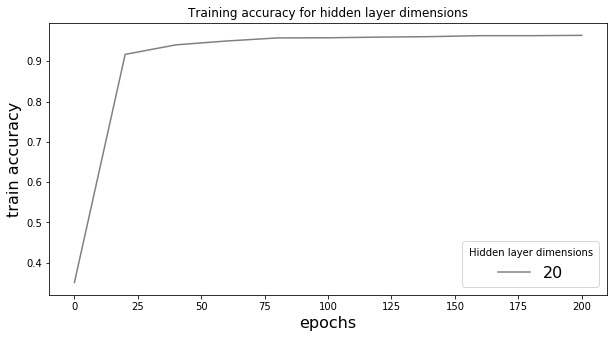

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]


<function matplotlib.pyplot.show(*args, **kw)>

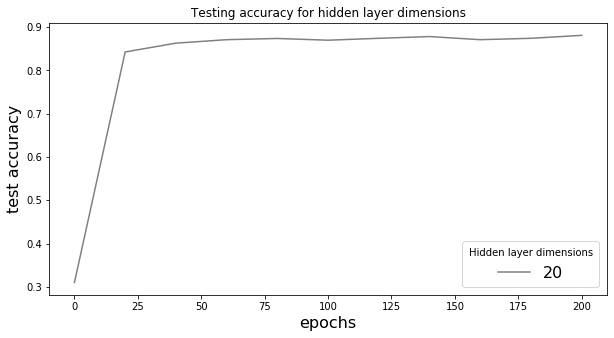

In [12]:
#Training results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
epochs_array = [i for i in range(0,200,20)]
epochs_array.append(200)
print(epochs_array)
ax.plot(epochs_array, nns[0].acc_train_array, color="grey", label=str(20))
ax.legend(title="Hidden layer dimensions", loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("train accuracy", fontsize=16)
ax.set_title("Training accuracy for hidden layer dimensions")
plt.show()

#Testing results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
epochs_array = [i for i in range(0,200,20)]
epochs_array.append(200)
print(epochs_array)
ax.plot(epochs_array, nns[0].acc_test_array, color="grey", label=str(20))
ax.legend(title="Hidden layer dimensions", loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("test accuracy", fontsize=16)
ax.set_title("Testing accuracy for hidden layer dimensions")
plt.show


Dropout_percentage:  0.1
Epoch    1: Train    0.15966, Test    0.16487
Epoch   20: Train    0.33854, Test    0.31212
Epoch   40: Train    0.52621, Test    0.45338
Epoch   60: Train    0.49580, Test    0.45298
Epoch   80: Train    0.51541, Test    0.47339
Epoch  100: Train    0.68587, Test    0.63145
Epoch  120: Train    0.55902, Test    0.49140
Epoch  140: Train    0.65906, Test    0.56263
Epoch  160: Train    0.65546, Test    0.61144
Epoch  180: Train    0.48699, Test    0.45498
Epoch  200: Train    0.61224, Test    0.56463

Dropout_percentage:  0.2
Epoch    1: Train    0.10564, Test    0.10964
Epoch   20: Train    0.62665, Test    0.60344
Epoch   40: Train    0.78391, Test    0.72629
Epoch   60: Train    0.76511, Test    0.69828
Epoch   80: Train    0.82113, Test    0.74030
Epoch  100: Train    0.81713, Test    0.75270
Epoch  120: Train    0.72469, Test    0.66947
Epoch  140: Train    0.80272, Test    0.73109
Epoch  160: Train    0.82833, Test    0.75110
Epoch  180: Train    0.83874

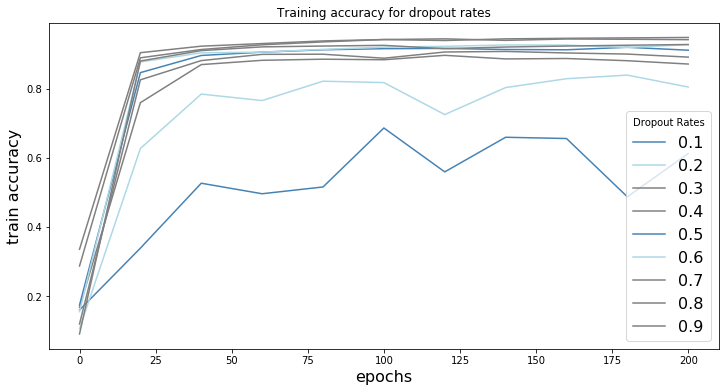

[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]


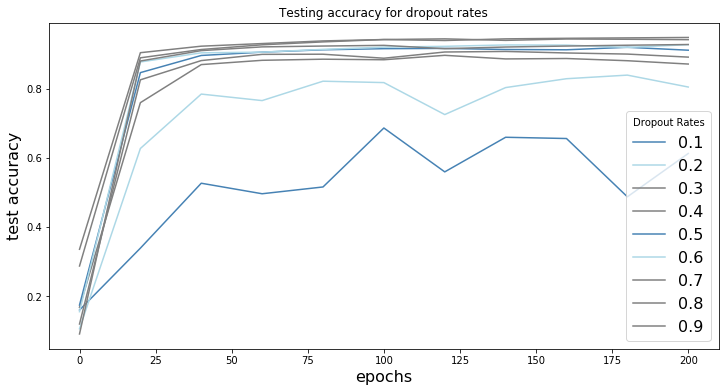

In [13]:
# Now try it with dropout
nns = []

for dropout_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print('\nDropout_percentage: ', dropout_percentage)
    nn = Network([input_dimensions, 20, output_dimensions], keep_prob=dropout_percentage)
    nns.append(nn)
    nn.SGD_train(train, epochs=200, eta=0.1, lam=0.0001, verbose=True, test=test)
    

#Training results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(0,200,20)]
epochs_array.append(200)
print(epochs_array)
ax.plot(epochs_array, nns[0].acc_train_array, color="steelblue", label=str(0.1))
ax.plot(epochs_array, nns[1].acc_train_array, color="lightblue", label=str(0.2))
ax.plot(epochs_array, nns[2].acc_train_array, color="grey", label=str(0.3))
ax.plot(epochs_array, nns[3].acc_train_array, color="grey", label=str(0.4))
ax.plot(epochs_array, nns[4].acc_train_array, color="steelblue", label=str(0.5))
ax.plot(epochs_array, nns[5].acc_train_array, color="lightblue", label=str(0.6))
ax.plot(epochs_array, nns[6].acc_train_array, color="grey", label=str(0.7))
ax.plot(epochs_array, nns[7].acc_train_array, color="grey", label=str(0.8))
ax.plot(epochs_array, nns[8].acc_train_array, color="grey", label=str(0.9))
ax.legend(title="Dropout Rates", loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("train accuracy", fontsize=16)
ax.set_title("Training accuracy for dropout rates")
plt.show()

#Testing results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
epochs_array = [i for i in range(0,200,20)]
epochs_array.append(200)
print(epochs_array)
ax.plot(epochs_array, nns[0].acc_train_array, color="steelblue", label=str(0.1))
ax.plot(epochs_array, nns[1].acc_train_array, color="lightblue", label=str(0.2))
ax.plot(epochs_array, nns[2].acc_train_array, color="grey", label=str(0.3))
ax.plot(epochs_array, nns[3].acc_train_array, color="grey", label=str(0.4))
ax.plot(epochs_array, nns[4].acc_train_array, color="steelblue", label=str(0.5))
ax.plot(epochs_array, nns[5].acc_train_array, color="lightblue", label=str(0.6))
ax.plot(epochs_array, nns[6].acc_train_array, color="grey", label=str(0.7))
ax.plot(epochs_array, nns[7].acc_train_array, color="grey", label=str(0.8))
ax.plot(epochs_array, nns[8].acc_train_array, color="grey", label=str(0.9))
ax.legend(title="Dropout Rates", loc="lower right", fontsize=16)
ax.set_xlabel("epochs", fontsize=16)
ax.set_ylabel("test accuracy", fontsize=16)
ax.set_title("Testing accuracy for dropout rates")
plt.show()

## Dropout example and explanation using Keras Dropout() layer with Fashion MNIST dataset

In [22]:
# Load the data

# Grab the train and test data sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Pre-processing

#X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train_df = pd.DataFrame(X_train)
print("Maximum value of X values: ", max(X_train_df.max()))

# normalize based on max value
# catch re-running exception where it's already normalized:
if max(X_train_df.max()) == 255.0:
    print("normalizing")
    X_train /= 255
    X_test /= 255
    
# Convert y to categorical outputs with one-hot encoding:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(y_train[0])

Maximum value of X values:  255.0
normalizing
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [23]:
# View the baseline with and without dropout

def make_nn(dropout_initial=0.1, dropout_hidden=0.5):
    model = Sequential()
    model.add(Dense(10, input_shape=(784,)))
    model.add(Dropout(dropout_hidden))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['categorical_accuracy'])

    return model

#F raction of the input units to drop.
dropout_rates_hidden = np.arange(0.0, 1.0, 0.10)
print(dropout_rates_hidden)
# dropout_rates_initial = np.arange(0.10, 0.6, 0.10)
# print(dropout_rates_initial)

accuracy_array_train = []
accuracy_array_val = []
accuracy_array_test = []
error_array_train = []
error_array_val = []
error_array_test = []

for i in dropout_rates_hidden:
    model = make_nn(dropout_hidden=i)
    history = model.fit(X_train, y_train, batch_size=48000, epochs=100, verbose=1, validation_split=0.2)
    # Test data
    test_scores = model.evaluate(X_test, y_test, verbose=1)
    # Train data
    accuracy_array_train.append(history.history['categorical_accuracy'])
    error_array_train.append(history.history['loss'])
    # Validation data
    accuracy_array_val.append(history.history['val_categorical_accuracy'])
    error_array_val.append(history.history['val_loss'])
    # Append test data
    accuracy_array_test.append(test_scores[1])
    error_array_test.append(test_scores[0])
    
accuracy_array_train = np.array(accuracy_array_train).T.tolist()
accuracy_array_val = np.array(accuracy_array_val).T.tolist()
error_array_train = np.array(error_array_train).T.tolist()
error_array_val = np.array(error_array_val).T.tolist()




[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 0s 10us/step - loss: 2.5351 - categorical_accuracy: 0.1120 - val_loss: 2.4647 - val_categorical_accuracy: 0.1273
Epoch 2/100
48000/48000 [==============================] - 0s 7us/step - loss: 2.4625 - categorical_accuracy: 0.1264 - val_loss: 2.4026 - val_categorical_accuracy: 0.1452
Epoch 3/100
48000/48000 [==============================] - 0s 7us/step - loss: 2.4015 - categorical_accuracy: 0.1434 - val_loss: 2.3493 - val_categorical_accuracy: 0.1671
Epoch 4/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.3493 - categorical_accuracy: 0.1635 - val_loss: 2.3030 - val_categorical_accuracy: 0.1869
Epoch 5/100
48000/48000 [==============================] - 0s 5us/step - loss: 2.3039 - categorical_accuracy: 0.1855 - val_loss: 2.2624 - val_categorical_accuracy: 0.2076
Epoch 6/100
48000/48000 [===========================

Max Test Accuracy: 0.6478000283241272


Text(0, 0.5, 'Accuracy')

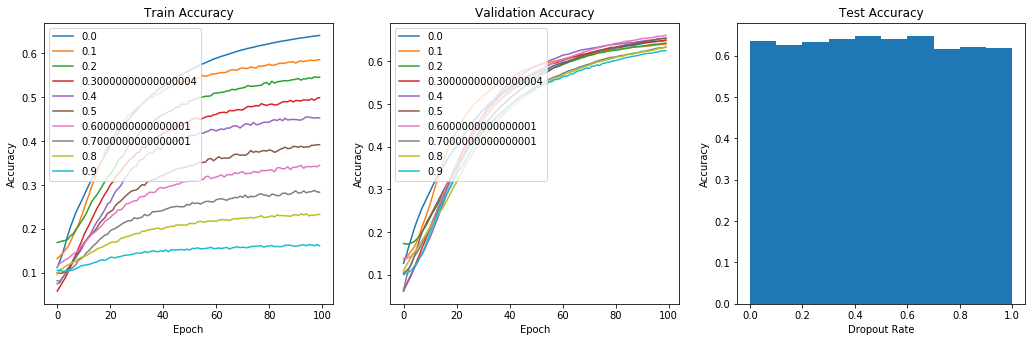

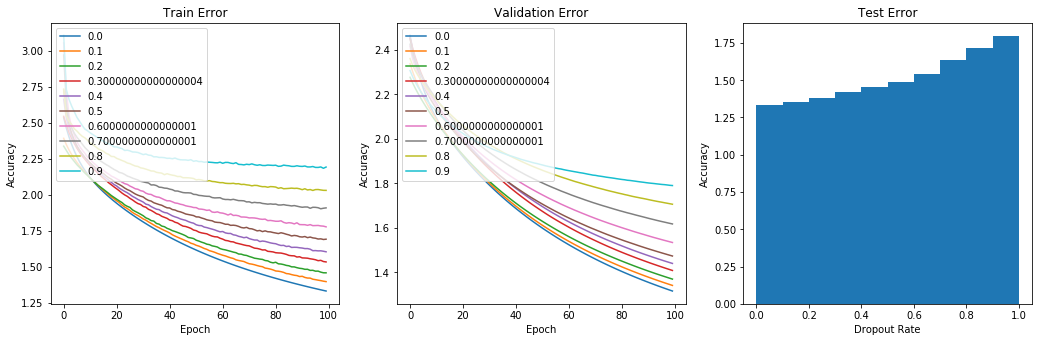

In [24]:
# Plot baseline 

# max text accuracy
print(f"Max Test Accuracy: {max(accuracy_array_test)}")

# summarize history for accuracy
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(5, 5, 1)
ax.plot(accuracy_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Accuracy')
ax1 = fig.add_subplot(5, 5, 2)
ax1.plot(accuracy_array_val)
ax1.title.set_text('Validation Accuracy')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, accuracy_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Accuracy')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')

# summarize loss
fig2 = plt.figure(figsize=(30, 30))
ax = fig2.add_subplot(5, 5, 1)
ax.plot(error_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Error')
ax1 = fig2.add_subplot(5, 5, 2)
ax1.plot(error_array_val)
ax1.title.set_text('Validation Error')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig2.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, error_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Error')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')



In [25]:
# Look at a better network

def make_nn(dropout_initial=0.1, dropout_hidden=0.5):
    NB_CLASSES = 10 
    model = Sequential()
    # CONV => RELU => POOL
    model.add(Dense(500, input_shape=(784,)))
    model.add(Dropout(dropout_hidden))
    model.add(Activation("relu"))
    # a softmax classifier
    model.add(Dense(NB_CLASSES))
    model.add(Dropout(dropout_hidden))
    model.add(Activation("softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["categorical_accuracy"])
    
    return model

#F raction of the input units to drop.
dropout_rates_hidden = np.arange(0.00, 1.0, 0.10)
print(dropout_rates_hidden)
# dropout_rates_initial = np.arange(0.10, 0.6, 0.10)
# print(dropout_rates_initial)

accuracy_array_train = []
accuracy_array_val = []
accuracy_array_test = []
error_array_train = []
error_array_val = []
error_array_test = []

for i in dropout_rates_hidden:
    model = make_nn(dropout_hidden=i)
    history = model.fit(X_train, y_train, batch_size=48000, epochs=30, verbose=1, validation_split=0.2)
    # Test data
    test_scores = model.evaluate(X_test, y_test, verbose=1)
    # Train data
    accuracy_array_train.append(history.history['categorical_accuracy'])
    error_array_train.append(history.history['loss'])
    # Validation data
    accuracy_array_val.append(history.history['val_categorical_accuracy'])
    error_array_val.append(history.history['val_loss'])
    # Append test data
    accuracy_array_test.append(test_scores[1])
    error_array_test.append(test_scores[0])

accuracy_array_train = np.array(accuracy_array_train).T.tolist()
accuracy_array_val = np.array(accuracy_array_val).T.tolist()
error_array_train = np.array(error_array_train).T.tolist()
error_array_val = np.array(error_array_val).T.tolist()



[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 1s 21us/step - loss: 2.3331 - categorical_accuracy: 0.1048 - val_loss: 1.8901 - val_categorical_accuracy: 0.3667
Epoch 2/30
48000/48000 [==============================] - 1s 21us/step - loss: 1.9031 - categorical_accuracy: 0.3582 - val_loss: 1.5456 - val_categorical_accuracy: 0.5192
Epoch 3/30
48000/48000 [==============================] - 1s 22us/step - loss: 1.5561 - categorical_accuracy: 0.5114 - val_loss: 1.2948 - val_categorical_accuracy: 0.6110
Epoch 4/30
48000/48000 [==============================] - 1s 23us/step - loss: 1.3015 - categorical_accuracy: 0.6068 - val_loss: 1.1241 - val_categorical_accuracy: 0.6410
Epoch 5/30
48000/48000 [==============================] - 1s 23us/step - loss: 1.1322 - categorical_accuracy: 0.6358 - val_loss: 1.0004 - val_categorical_accuracy: 0.6676
Epoch 6/30
48000/48000 [=============================

Max Test Accuracy: 0.8116000294685364


Text(0, 0.5, 'Accuracy')

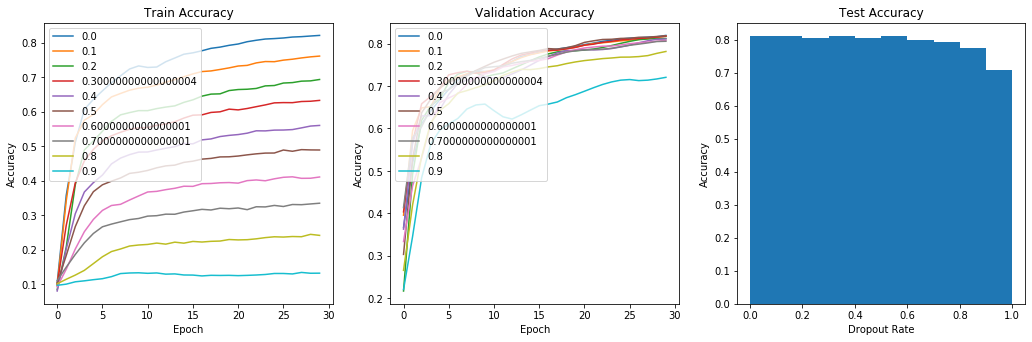

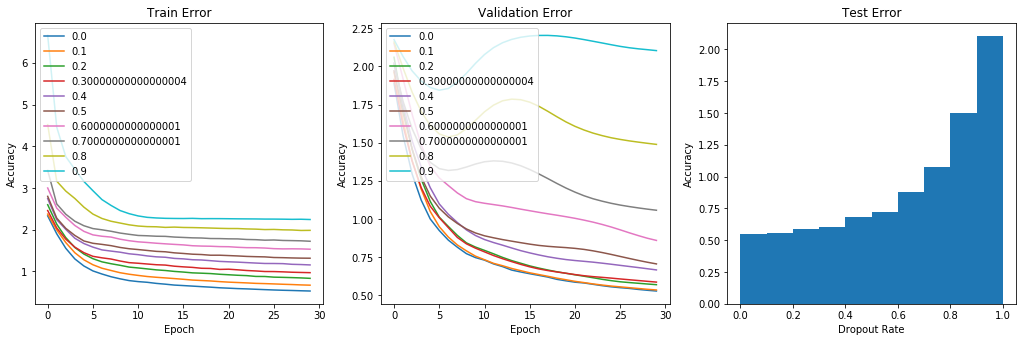

In [26]:
# Plot better network

# max text accuracy
print(f"Max Test Accuracy: {max(accuracy_array_test)}")

# summarize history for accuracy
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(5, 5, 1)
ax.plot(accuracy_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Accuracy')
ax1 = fig.add_subplot(5, 5, 2)
ax1.plot(accuracy_array_val)
ax1.title.set_text('Validation Accuracy')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, accuracy_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Accuracy')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')

# summarize loss
fig2 = plt.figure(figsize=(30, 30))
ax = fig2.add_subplot(5, 5, 1)
ax.plot(error_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Error')
ax1 = fig2.add_subplot(5, 5, 2)
ax1.plot(error_array_val)
ax1.title.set_text('Validation Error')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig2.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, error_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Error')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')



source: https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

## Tips For Using Dropout
The original paper on Dropout provides experimental results on a suite of standard machine learning problems. As a result they provide a number of useful heuristics to consider when using dropout in practice.

- Generally, use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
- Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.
- Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
- Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
- Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.

This can be done with:
```
# try best with: 
opt = SGD(lr=0.01, momentum=0.9)
opt = Adam(lr=0.01)
model.compile(..., optimizer=opt)

# instantiate norm
model.add(Dense(32, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(Conv2D(32, (3,3), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(LSTM(32, kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
```

In [27]:
# try with above recommended high momentum, high lr, and max_norm 

opt = Adam(lr=0.01)

# import norm


# Look at a better network with lr, momentum, and max norm
def make_nn(dropout_initial=0.1, dropout_hidden=0.5):
    NB_CLASSES = 10 
    model = Sequential()
    # CONV => RELU => POOL
    model.add(Dense(500, input_shape=(784,),kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(Dropout(dropout_hidden))
    model.add(Activation("relu"))
    # a softmax classifier
    model.add(Dense(NB_CLASSES,kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(Dropout(dropout_hidden))
    model.add(Activation("softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["categorical_accuracy"])
    
    return model

#Fraction of the input units to drop.
dropout_rates_hidden = np.arange(0.00, 1.0, 0.10)
print(dropout_rates_hidden)
# dropout_rates_initial = np.arange(0.10, 0.6, 0.10)
# print(dropout_rates_initial)

accuracy_array_train = []
accuracy_array_val = []
accuracy_array_test = []
error_array_train = []
error_array_val = []
error_array_test = []

for i in dropout_rates_hidden:
    model = make_nn(dropout_hidden=i)
    history = model.fit(X_train, y_train, batch_size=48000, epochs=30, verbose=1, validation_split=0.2)
    # Test data
    test_scores = model.evaluate(X_test, y_test, verbose=1)
    # Train data
    accuracy_array_train.append(history.history['categorical_accuracy'])
    error_array_train.append(history.history['loss'])
    # Validation data
    accuracy_array_val.append(history.history['val_categorical_accuracy'])
    error_array_val.append(history.history['val_loss'])
    # Append test data
    accuracy_array_test.append(test_scores[1])
    error_array_test.append(test_scores[0])

accuracy_array_train = np.array(accuracy_array_train).T.tolist()
accuracy_array_val = np.array(accuracy_array_val).T.tolist()
error_array_train = np.array(error_array_train).T.tolist()
error_array_val = np.array(error_array_val).T.tolist()



[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 2s 39us/step - loss: 2.3865 - categorical_accuracy: 0.1077 - val_loss: 1.8899 - val_categorical_accuracy: 0.4201
Epoch 2/30
48000/48000 [==============================] - 1s 30us/step - loss: 1.9015 - categorical_accuracy: 0.4132 - val_loss: 1.5664 - val_categorical_accuracy: 0.5244
Epoch 3/30
48000/48000 [==============================] - 1s 26us/step - loss: 1.5773 - categorical_accuracy: 0.5157 - val_loss: 1.2857 - val_categorical_accuracy: 0.6258
Epoch 4/30
48000/48000 [==============================] - 1s 28us/step - loss: 1.2961 - categorical_accuracy: 0.6220 - val_loss: 1.1360 - val_categorical_accuracy: 0.6597
Epoch 5/30
48000/48000 [==============================] - 1s 28us/step - loss: 1.1479 - categorical_accuracy: 0.6506 - val_loss: 1.0380 - val_categorical_accuracy: 0.6736
Epoch 6/30
48000/48000 [=============================

Max Test Accuracy: 0.8126999735832214


Text(0, 0.5, 'Accuracy')

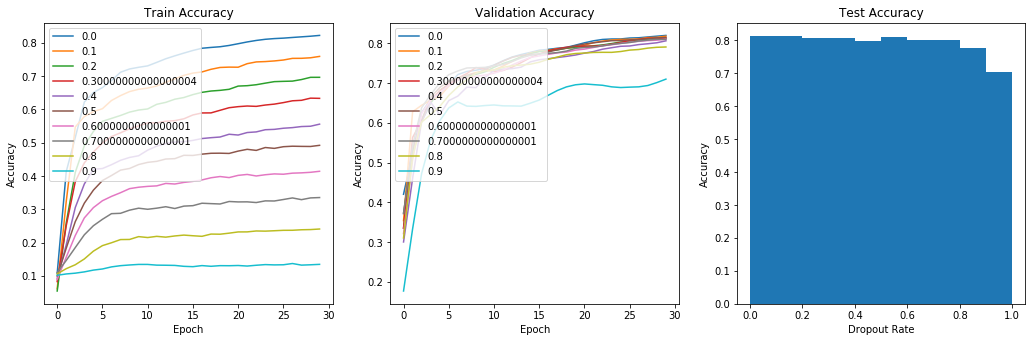

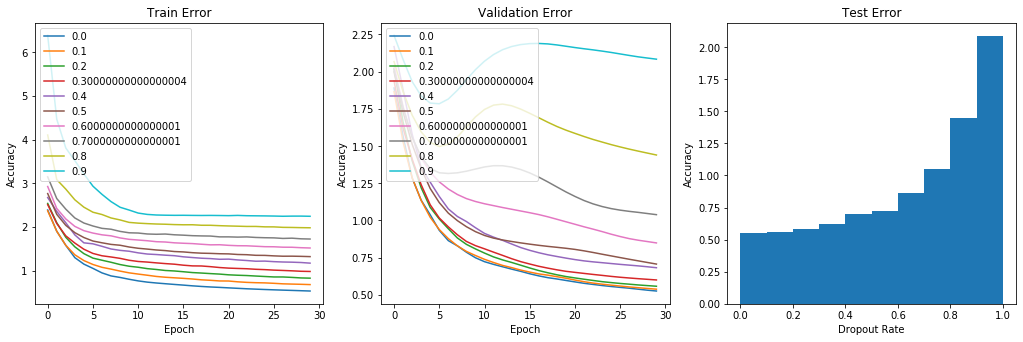

In [28]:
# plot recommended parameters

# max text accuracy
print(f"Max Test Accuracy: {max(accuracy_array_test)}")

# summarize history for accuracy
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(5, 5, 1)
ax.plot(accuracy_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Accuracy')
ax1 = fig.add_subplot(5, 5, 2)
ax1.plot(accuracy_array_val)
ax1.title.set_text('Validation Accuracy')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, accuracy_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Accuracy')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')

# summarize loss
fig2 = plt.figure(figsize=(30, 30))
ax = fig2.add_subplot(5, 5, 1)
ax.plot(error_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Error')
ax1 = fig2.add_subplot(5, 5, 2)
ax1.plot(error_array_val)
ax1.title.set_text('Validation Error')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig2.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, error_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Error')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')



In [29]:
# look at just accuracy, not categorical_accuracy

opt = Adam(lr=0.01)

# Look at a better network with lr, and max norm
def make_nn(dropout_initial=0.1, dropout_hidden=0.5):
    NB_CLASSES = 10 
    model = Sequential()
    # CONV => RELU => POOL
    model.add(Dense(500, input_shape=(784,),kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(Dropout(dropout_hidden))
    model.add(Activation("relu"))
    # a softmax classifier
    model.add(Dense(NB_CLASSES,kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(Dropout(dropout_hidden))
    model.add(Activation("softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
    
    return model

#Fraction of the input units to drop.
dropout_rates_hidden = np.arange(0.00, 1.0, 0.10)
print(dropout_rates_hidden)
# dropout_rates_initial = np.arange(0.10, 0.6, 0.10)
# print(dropout_rates_initial)

accuracy_array_train = []
accuracy_array_val = []
accuracy_array_test = []
error_array_train = []
error_array_val = []
error_array_test = []

for i in dropout_rates_hidden:
    model = make_nn(dropout_hidden=i)
    history = model.fit(X_train, y_train, batch_size=48000, epochs=30, verbose=1, validation_split=0.2)
    # Test data
    test_scores = model.evaluate(X_test, y_test, verbose=1)
    # Train data
    accuracy_array_train.append(history.history['accuracy'])
    error_array_train.append(history.history['loss'])
    # Validation data
    accuracy_array_val.append(history.history['val_accuracy'])
    error_array_val.append(history.history['val_loss'])
    # Append test data
    accuracy_array_test.append(test_scores[1])
    error_array_test.append(test_scores[0])

accuracy_array_train = np.array(accuracy_array_train).T.tolist()
accuracy_array_val = np.array(accuracy_array_val).T.tolist()
error_array_train = np.array(error_array_train).T.tolist()
error_array_val = np.array(error_array_val).T.tolist()



[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 2s 50us/step - loss: 2.5720 - accuracy: 0.0414 - val_loss: 2.0616 - val_accuracy: 0.2222
Epoch 2/30
48000/48000 [==============================] - 2s 49us/step - loss: 2.0600 - accuracy: 0.2174 - val_loss: 1.7557 - val_accuracy: 0.4470
Epoch 3/30
48000/48000 [==============================] - 2s 38us/step - loss: 1.7594 - accuracy: 0.4453 - val_loss: 1.4872 - val_accuracy: 0.5570
Epoch 4/30
48000/48000 [==============================] - 2s 40us/step - loss: 1.4962 - accuracy: 0.5551 - val_loss: 1.2680 - val_accuracy: 0.6269
Epoch 5/30
48000/48000 [==============================] - 2s 41us/step - loss: 1.2784 - accuracy: 0.6225 - val_loss: 1.1017 - val_accuracy: 0.6659
Epoch 6/30
48000/48000 [==============================] - 2s 39us/step - loss: 1.1113 - accuracy: 0.6631 - val_loss: 0.9927 - val_accuracy: 0.6891
Epoch 7/30
48000/48000 [==

Max Test Accuracy: 0.8154000043869019


Text(0, 0.5, 'Accuracy')

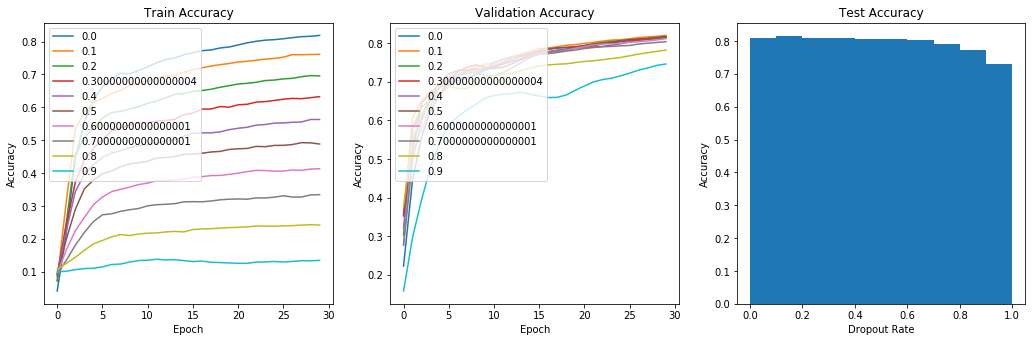

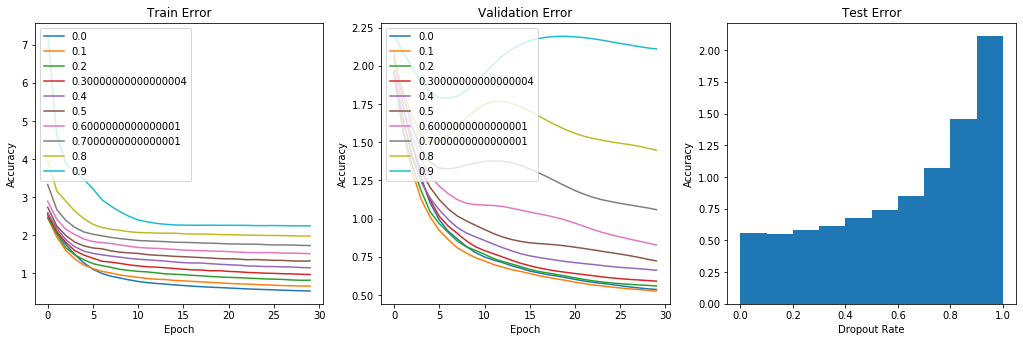

In [30]:
# max text accuracy
print(f"Max Test Accuracy: {max(accuracy_array_test)}")

# summarize history for accuracy
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(5, 5, 1)
ax.plot(accuracy_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Accuracy')
ax1 = fig.add_subplot(5, 5, 2)
ax1.plot(accuracy_array_val)
ax1.title.set_text('Validation Accuracy')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, accuracy_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Accuracy')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')

# summarize loss
fig2 = plt.figure(figsize=(30, 30))
ax = fig2.add_subplot(5, 5, 1)
ax.plot(error_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Error')
ax1 = fig2.add_subplot(5, 5, 2)
ax1.plot(error_array_val)
ax1.title.set_text('Validation Error')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig2.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, error_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Error')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')



In [31]:
# Reload data into different shape
# Source https://keras.io/examples/mnist_cnn/
img_rows, img_cols = 28, 28
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)


X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [32]:
# Source: https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/
# with a few changes: added learning rate and max norm

opt = Adam(lr=0.01)
# Look at a recommended model
def make_nn(dropout_initial=0.1, dropout_hidden=0.5):
    model = Sequential()   
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape, kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(Conv2D(64, (3, 3), activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_hidden))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.add(Dropout(dropout_hidden))
    model.add(Dense(10, activation='softmax',kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["categorical_accuracy"])

    return model

#F raction of the input units to drop.
dropout_rates_hidden = np.arange(0.00, 1.0, 0.10)
print(dropout_rates_hidden)
# dropout_rates_initial = np.arange(0.10, 0.6, 0.10)
# print(dropout_rates_initial)

accuracy_array_train = []
accuracy_array_val = []
accuracy_array_test = []
error_array_train = []
error_array_val = []
error_array_test = []

for i in dropout_rates_hidden:
    model = make_nn(dropout_hidden=i)
    history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.1)
    # Test data
    test_scores = model.evaluate(X_test, y_test, verbose=1)
    # Train data
    accuracy_array_train.append(history.history['categorical_accuracy'])
    error_array_train.append(history.history['loss'])
    # Validation data
    accuracy_array_val.append(history.history['val_categorical_accuracy'])
    error_array_val.append(history.history['val_loss'])
    # Append test data
    accuracy_array_test.append(test_scores[1])
    error_array_test.append(test_scores[0])

accuracy_array_train = np.array(accuracy_array_train).T.tolist()
accuracy_array_val = np.array(accuracy_array_val).T.tolist()
error_array_train = np.array(error_array_train).T.tolist()
error_array_val = np.array(error_array_val).T.tolist()



[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 169s 3ms/step - loss: 0.4359 - categorical_accuracy: 0.8441 - val_loss: 0.3396 - val_categorical_accuracy: 0.8737
Epoch 2/10
54000/54000 [==============================] - 171s 3ms/step - loss: 0.3356 - categorical_accuracy: 0.8774 - val_loss: 0.3202 - val_categorical_accuracy: 0.8833
Epoch 3/10
54000/54000 [==============================] - 158s 3ms/step - loss: 0.3202 - categorical_accuracy: 0.8809 - val_loss: 0.3009 - val_categorical_accuracy: 0.8892
Epoch 4/10
54000/54000 [==============================] - 92s 2ms/step - loss: 0.3086 - categorical_accuracy: 0.8861 - val_loss: 0.3064 - val_categorical_accuracy: 0.8840
Epoch 5/10
54000/54000 [==============================] - 90s 2ms/step - loss: 0.2972 - categorical_accuracy: 0.8904 - val_loss: 0.3066 - val_categorical_accuracy: 0.8890
Epoch 6/10
54000/54000 [===========================

Max Test Accuracy: 0.8822000026702881


Text(0, 0.5, 'Accuracy')

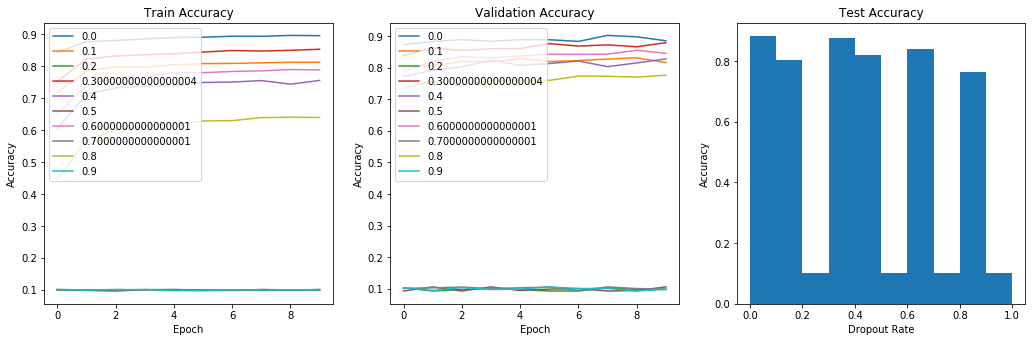

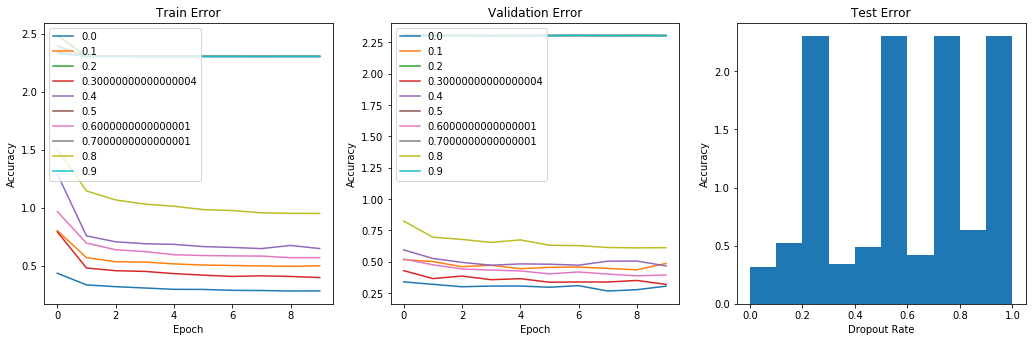

In [33]:
# plot best model found with added LR and max norm
# max text accuracy
print(f"Max Test Accuracy: {max(accuracy_array_test)}")

# summarize history for accuracy
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(5, 5, 1)
ax.plot(accuracy_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Accuracy')
ax1 = fig.add_subplot(5, 5, 2)
ax1.plot(accuracy_array_val)
ax1.title.set_text('Validation Accuracy')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, accuracy_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Accuracy')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')

# summarize loss
fig2 = plt.figure(figsize=(30, 30))
ax = fig2.add_subplot(5, 5, 1)
ax.plot(error_array_train)
ax.legend(dropout_rates_hidden, loc='upper left')
ax.title.set_text('Train Error')
ax1 = fig2.add_subplot(5, 5, 2)
ax1.plot(error_array_val)
ax1.title.set_text('Validation Error')
ax1.legend(dropout_rates_hidden, loc='upper left')
ax2 = fig2.add_subplot(5, 5, 3)
ax2.bar(dropout_rates_hidden, error_array_test, align='edge', width=0.10)
ax2.title.set_text('Test Error')

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Accuracy')

